# Tara Sequencer

In [1]:
# imports
from importlib import reload
import numpy as np
import pandas
import datetime

from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy

import seaborn as sns

from oceancolor.tara import io
from oceancolor.tara import spectra

import sequencer
from sequencer import sequencer_

# Load the Table

In [2]:
tara_db = io.load_tara_db()

# Process the spectra

In [3]:
reload(spectra)
wv_nm, all_a_ph, all_a_ph_sig = spectra.spectra_from_table(tara_db)
wv_grid = np.arange(402.5, 707.5, 5.)
rwv_nm, r_aph, r_sig = spectra.rebin_to_grid(wv_nm, all_a_ph, all_a_ph_sig, wv_grid)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:248: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:249: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)


In [4]:
r_aph.shape

(302779, 60)

# Remove bad spectra

In [5]:
tot_spec = np.nansum(r_aph, axis=-1)
gd_tot = tot_spec > 0.

## S/N

In [6]:
med_sn = np.nanmedian(r_aph/r_sig, axis=1)
med_sn.shape

/tmp/ipykernel_11789/2623766664.py:1: RuntimeWarning: divide by zero encountered in divide
  med_sn = np.nanmedian(r_aph/r_sig, axis=1)
/tmp/ipykernel_11789/2623766664.py:1: RuntimeWarning: invalid value encountered in divide
  med_sn = np.nanmedian(r_aph/r_sig, axis=1)


(302779,)

In [9]:
med_sn.min()

-1.5384615384615385

<Axes: ylabel='Count'>

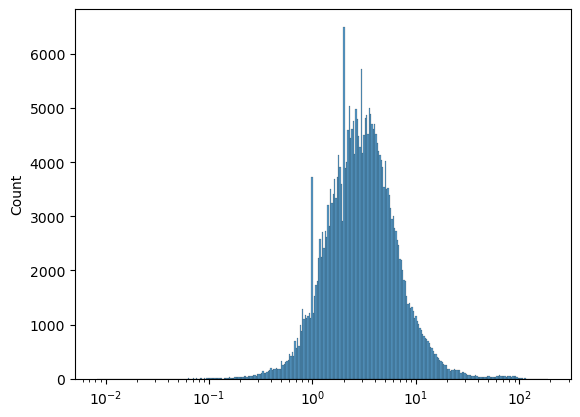

In [10]:
sns.histplot(med_sn[med_sn>0], log_scale=(True,False))

In [11]:
np.sum(med_sn > 1.)

279183

## cut

In [6]:
cull_raph = r_aph[gd_tot, :]
cull_rsig = r_sig[gd_tot, :]

# Deal with NaN

In [7]:
bad = np.isnan(cull_raph) | (cull_rsig <= 0.) | (cull_raph <0.)
print(f'Nbad = {np.sum(bad)}')
# Replace
cull_raph[bad] = 1e-5
cull_rsig[bad] = 1e5

Nbad = 81851


# Start with a random set of spectra

In [8]:
rand = np.random.choice(np.arange(cull_raph.shape[0]), size=100, replace=False)
rand_raph = cull_raph[rand,:]

# Normalize them (un-normalized will occur later)

In [21]:
np.sum(rand_raph, axis=1).shape

(100,)

In [22]:
rand_raph /= np.outer(np.sum(rand_raph, axis=1), np.ones(rand_raph.shape[1]))
rand_raph.shape

(100, 60)

# Init the Sequencer

In [23]:
reload(sequencer_)
grid = np.arange(len(rwv_nm))
estimator_list = ['EMD', 'energy', 'L2'] # Removed KL because of the 0 values
#estimator_list = ['EMD', 'L2', 'KL'] # Removed KL because of the 0 values

seq = sequencer.Sequencer(grid, rand_raph, estimator_list)

# Run it

## Output directory

In [32]:
# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "/home/xavier/Projects/Oceanography/Color/Sequencer/Tara/Norm"
final_elongation, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 0.16121387481689453 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 0.29834961891174316 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 0.1594531536102295 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 0.3078598976135254 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished calculating this distance matrix list, it took: 0.013694047927856445 seconds
calculating the distance matrices for estimator: L2, scale: 2
finished calculating this distance matrix list, it took: 0.02709174156188965 seconds
dumped the distance matrix dictionaries to the file: /home/xavier/Projects/Oceanography/Color/Sequencer/Tara/

# Explore

In [25]:
# print the resulting elongation
print("resulting elongation: ", final_elongation)


# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()


print("intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   np.round(elongation_list[i], 2)))


resulting elongation:  8.065000000000001
intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 18.44
metric=EMD, scale=2, elongation: 16.2
metric=energy, scale=1, elongation: 12.84
metric=energy, scale=2, elongation: 16.37
metric=L2, scale=1, elongation: 5.4
metric=L2, scale=2, elongation: 12.13


In [26]:
estimator_list, scale_list, sequence_list = seq.return_sequence_of_weighted_products_all_metrics_and_scales()

In [27]:
best = sequence_list[1]
final_sequence = best

Text(0, 0.5, 'object index')

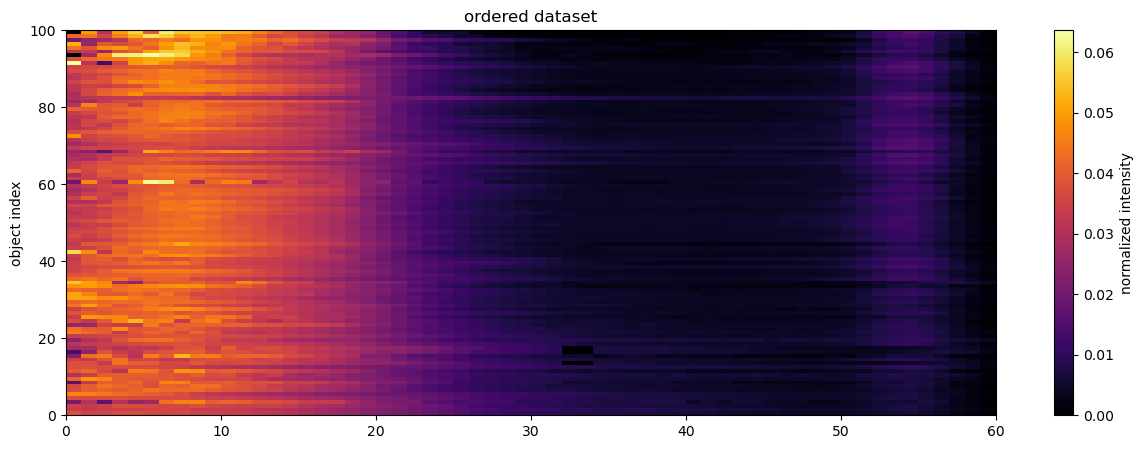

In [28]:
# plot the ordered dataset
reorder_raph = rand_raph[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("ordered dataset")
#plt.pcolormesh(rand_raph, cmap="inferno")
plt.pcolormesh(reorder_raph, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

Text(0, 0.5, 'object index')

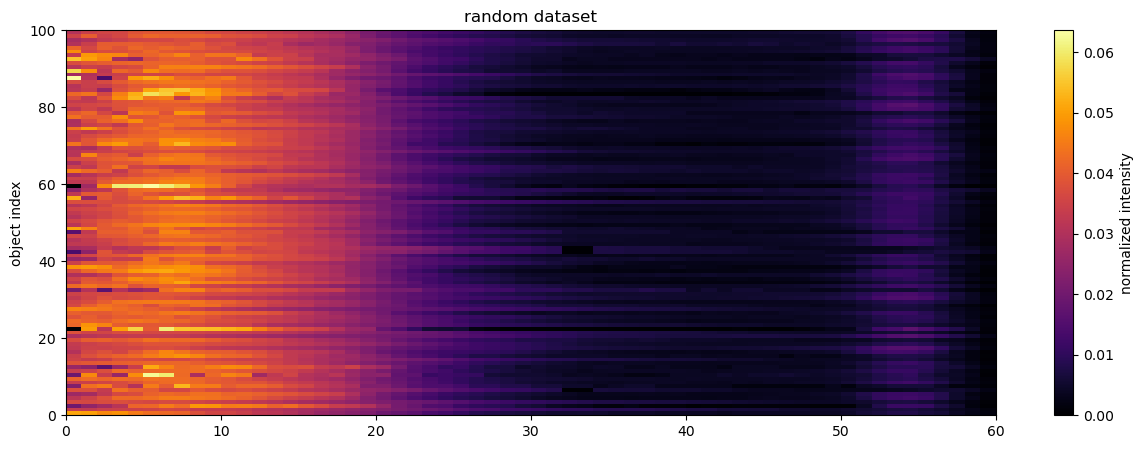

In [31]:
# plot the ordered dataset
#reorder_raph = rand_raph[final_sequence, :]

plt.figure(1, figsize=(15, 5))
plt.title("random dataset")
plt.pcolormesh(rand_raph, cmap="inferno")
#plt.pcolormesh(reorder_raph, cmap="inferno")
plt.colorbar(label="normalized intensity")
plt.ylabel("x")
plt.ylabel("object index")

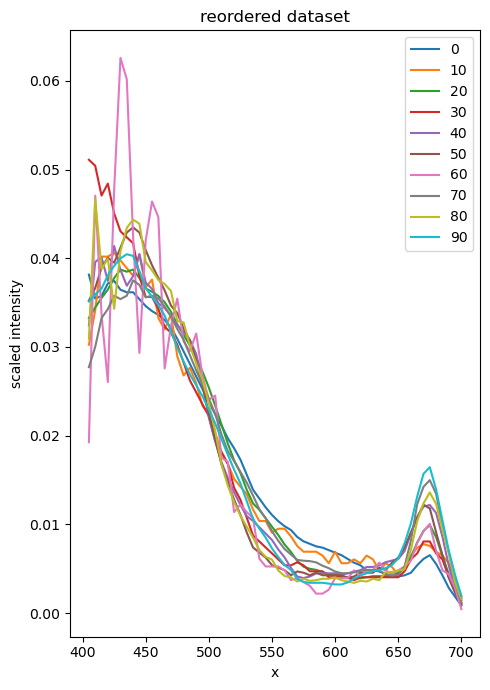

In [33]:
plt.figure(1, figsize=(5, 7))
plt.title("reordered dataset")
ax = plt.gca()
for ii in range(0,len(final_sequence),10):
    #object_data_scaled_y = object_data + i*1.5 # scale the objects so they will not be one on top of the other
    ax.plot(rwv_nm, reorder_raph[ii,:], label=f'{ii}')#, "k")
    
plt.xlabel("x")
plt.ylabel("scaled intensity")
ax.legend()
plt.tight_layout()
plt.show()

In [18]:
# 

----

# Debuggin

In [23]:
norm = np.sum(r_aph, axis=-1)
norm.size

302779

In [25]:
bad = norm <= 0.
np.sum(bad)

15